# Cluster Italian Restaurants and Perform Cluster Analysis

In [92]:
import pandas as pd
import numpy as np
import requests
import branca
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

In [93]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import sent_tokenize,word_tokenize 
from nltk.book import *
import gensim.summarization

### Read All Italian Restaurants With Reviews Scrapped

In [94]:
df = pd.read_pickle("./italian_review_551.pkl")

### Functions To Summarize Cluster Information

In [107]:
def do_tag(df):
    df = df.reset_index(drop=True)
    #----------------------------------------------------
    # Extract all category tags for italian restaurants
    def get_cat(df):
        N = len(df)
        italian_cat = []
        for i in range(N):
            italian_cat.extend(df.categories[i])
        italian_cat_set = set(italian_cat)
        return italian_cat_set
    
    #----------------------------------------------------
    # Make each tag a column and add to df
    italian_cat_set = get_cat(df)
    italian_cat_set.remove('italian')
    for i in italian_cat_set:
        df[str(i)]=[(str(i) in df.categories[j])*1 for j in range(len(df))]
    
    #----------------------------------------------------
    # Create a new df only with all categories
    index = list(df.index.unique().values)
    columns = list(italian_cat_set)
    df_new = pd.DataFrame(index=index, columns=columns)
    
    # Add tag columns to df_new to fit linear model
    df_new['rating'] = df['rating']
    for i in italian_cat_set:    
        df_new[str(i)]=df[str(i)]
          
    #----------------------------------------------------
    # Apply Linear Regression to df_new to get most effective tags
    Y = df_new['rating']
    X = df_new[columns]
    model = LinearRegression().fit(X,Y)
    intercept = model.intercept_
    coef = model.coef_
    # Find top 5 tags
    d = list(zip(coef,columns))
    do_not_tag = sorted(d)[:5]
    do_tag = sorted(d)[-5:]
    do_tag_cat = [tag[1] for tag in do_tag]
    do_not_tag_cat = [tag[1] for tag in do_not_tag]
    
#     print(italian_cat_set)
#     print('Do Tag: ',do_tag_cat)
#     print('Do Not Tag: ',do_not_tag_cat)
    return do_tag_cat, do_not_tag_cat

In [108]:
# def do_tag(df):
#     df = df.reset_index(drop=True)
#     #----------------------------------------------------
#     # Extract all category tags for italian restaurants
#     def get_cat(df):
#         N = len(df)
#         italian_cat = []
#         for i in range(N):
#             italian_cat.extend(df.categories[i])
#         italian_cat_set = set(italian_cat)
#         return italian_cat_set
    
#     #----------------------------------------------------
#     # Make each tag a column and add to df
#     italian_cat_set = get_cat(df)
#     italian_cat_set.remove('italian')
#     for i in italian_cat_set:
#         df[str(i)]=[(str(i) in df.categories[j])*1 for j in range(len(df))]
    
#     #----------------------------------------------------
#     # Create a new df only with all categories
#     index = list(df.index.unique().values)
#     columns = list(italian_cat_set)
#     df_new = pd.DataFrame(index=index, columns=columns)
    
#     # Add tag columns to df_new to fit linear model
#     df_new['rating'] = df['rating']
#     for i in italian_cat_set:    
#         df_new[str(i)]=df[str(i)]
          
#     #----------------------------------------------------
#     # Apply Linear Regression to df_new to get most effective tags
#     Y = df_new['rating']
#     X = df_new[columns]
#     model = LinearRegression().fit(X,Y)
#     intercept = model.intercept_
#     coef = model.coef_
#     # Find top 5 tags
#     d = list(zip(coef,columns))
#     do_not_tag = sorted(d)[:5]
#     do_tag = sorted(d)[-5:]
#     do_tag_cat = [tag[1] for tag in do_tag]
#     do_not_tag_cat = [tag[1] for tag in do_not_tag]
    
# #     print(italian_cat_set)
# #     print('Do Tag: ',do_tag_cat)
# #     print('Do Not Tag: ',do_not_tag_cat)
#     return do_tag_cat, do_not_tag_cat

In [109]:
def service(df):
    df = df.reset_index(drop=True)
    #----------------------------------------------------
    # Create a new df only with all categories
    index = list(df.index.unique().values)
    columns = ['pickup','delivery','restaurant_reservation']
    df_service = pd.DataFrame(index=index, columns=columns)
    
    # Add tag columns to df_new to fit linear model
    df_service['rating'] = df['rating']
    for i in columns:    
        df_service[str(i)]=df[str(i)]*1
    
    #--------------------------------------------------------------------------
    # Apply Linear Regression on Service Types to find how significant they are
    Y = df_service['rating']
    X = df_service[columns]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    result = model.fit()
    parameter = result.params[1:]
    pvalue = result.pvalues[1:]
    
    # Store model outputs for service types
    service_dict = {}
    for i in range(len(columns)):
        if parameter[i]>0:
            service_dict[columns[i]] = parameter[i]
    service_dict
    
    # Record pvalues for later use
    pvalue_dict={}
    for i in range(len(columns)):
        pvalue_dict[columns[i]+'_p_value'] = pvalue[i]
    pvalue_dict
    
#     print('Significance of Service Types:', service_dict)
#     print('P-value of Service Types:', pvalue_dict)
    return service_dict, pvalue_dict

In [110]:
def avg_price(df):
    df = df.reset_index(drop=True)
    avg_price = np.mean(df['price_num'])
    return avg_price

In [111]:
def avg_rate(df):
    df = df.reset_index(drop=True)
    avg_rate = np.mean(df['avg_rate'])
    return avg_rate

In [112]:
df_new = df[['longitude','latitude']]

In [113]:
# clustering
np.random.seed(0)
from sklearn.cluster import KMeans
# number of clusters
k = 5
kmeans = KMeans(n_clusters=k,n_init=30)
# fitting the input data
kmeans = kmeans.fit(df_new)
# getting the cluster labels
labels = kmeans.predict(df_new)
# centroid values
centroids = kmeans.cluster_centers_

In [114]:
df['label'] = labels
area_label = np.unique(df['label'])

In [115]:
print(centroids)

[[-73.98057001  40.76445118]
 [-73.99983004  40.72339522]
 [-73.93448251  40.84954605]
 [-73.98835069  40.73839707]
 [-73.9568894   40.78471502]]


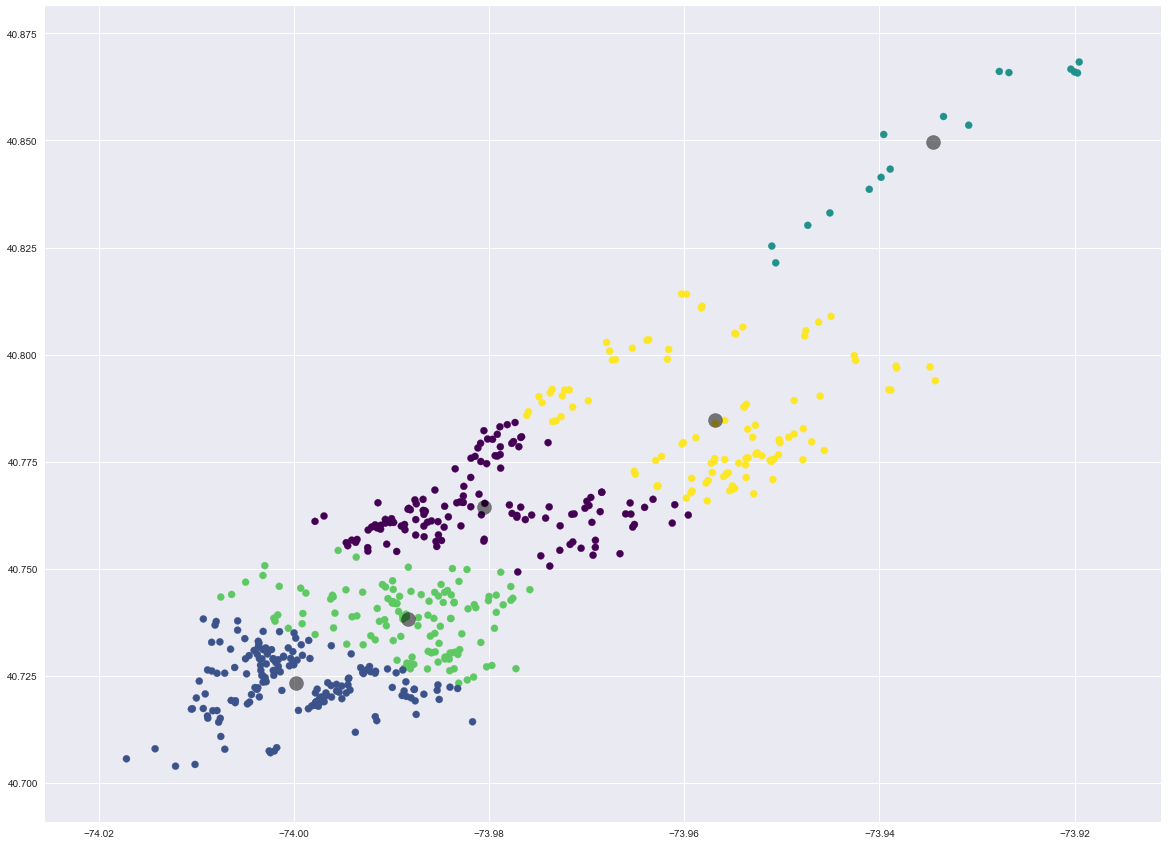

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.scatter(df_new['longitude'], df_new['latitude'], c=labels, s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)

In [117]:
def fancy_table(df,row):
    i = row
    title = 'Analysis of Cluster ' + str(i)
    average_price = df['average price'].iloc[i]                             
    recommended_tags = df['recommended tags'].iloc[i]                           
    non_recommended_tags = df['non-recommended tags'].iloc[i]
    average_rating = df['average rating'].iloc[i]                                           
    recommended_service = df['recommended service'].iloc[i]                               
    
    left_col_colour = "#2A799C"
    right_col_colour = "#C5DCE7"
    
    html =  """<!DOCTYPE html>
            <html>

            <head>
            <h4 style="margin-bottom:0"; width="600px">{}</h4>""".format(title) + """

            </head>
                <table style="height: 126px; width: 600px;">
            <tbody>
            <tr>
            <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Average Rating</span></td>
            <td style="width: 600px;background-color: """+ right_col_colour +""";">{}</td>""".format(average_rating) + """
            </tr>
            <tr>
            <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Average Price Level</span></td>
            <td style="width: 600px;background-color: """+ right_col_colour +""";">{}</td>""".format(average_price) + """
            </tr>
            <tr>
            <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Tags Recommended</span></td>
            <td style="width: 600px;background-color: """+ right_col_colour +""";">{}</td>""".format(recommended_tags) + """
            </tr>
            <tr>
            <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Tags Not Recommended</span></td>
            <td style="width: 600px;background-color: """+ right_col_colour +""";">{}</td>""".format(non_recommended_tags) + """
            </tr>
            <tr>
            <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Recommended Service</span></td>
            <td style="width: 600px;background-color: """+ right_col_colour +""";">{}</td>""".format(recommended_service) + """
            </tr>
            </tbody>
            </table>
            </html>
            """
    return html

In [118]:
df_cluster = pd.DataFrame(columns=['recommended tags','non-recommended tags','average price','average rating','recommended service'],index=list(range(5)))
for i in range(5):
    df_cluster['recommended tags'].iloc[i] = do_tag(df[df['label']==i])[0]
    df_cluster['non-recommended tags'].iloc[i] = do_tag(df[df['label']==i])[1]
    df_cluster['recommended service'].iloc[i] = list(service(df[df['label']==i])[0].keys())
    df_cluster['average price'].iloc[i] = avg_price(df[df['label']==i])
    df_cluster['average rating'].iloc[i] = avg_rate(df[df['label']==i])

/Users/qihanliang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/qihanliang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qihanliang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/qihanliang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [119]:
zip_groups = df.groupby("zip")
sizes = pd.DataFrame(zip_groups.size())
sizes.rename(columns={0:"size"},inplace=True)
sizes.reset_index(level=0, inplace=True)
import folium
from folium.plugins import MarkerCluster
#Center the map at Times Square
m = folium.Map(width=1200,height=1200,location = [40.7589,-73.9851],zoom_start=12)

# clustered marker
marker_cluster = MarkerCluster().add_to(m)
for i in range(len(df_new)):
    
    if df['label'].iloc[i] == 0:
        folium.Marker(location=[df_new['latitude'].iloc[i],df_new['longitude'].iloc[i]],
        popup=df['name'].iloc[i],
        icon=folium.Icon(color='red')
        ).add_to(marker_cluster)   
    elif df['label'].iloc[i] == 1:
        folium.Marker(location=[df_new['latitude'].iloc[i],df_new['longitude'].iloc[i]],
        popup=df['name'].iloc[i],
        icon=folium.Icon(color='orange')
        ).add_to(marker_cluster)
    elif df['label'].iloc[i] == 2:
        folium.Marker(location=[df_new['latitude'].iloc[i],df_new['longitude'].iloc[i]],
        popup=df['name'].iloc[i],
        icon=folium.Icon(color='green')
        ).add_to(marker_cluster)
    elif df['label'].iloc[i] == 3:
        folium.Marker(location=[df_new['latitude'].iloc[i],df_new['longitude'].iloc[i]],
        popup=df['name'].iloc[i],
        icon=folium.Icon(color='purple')
        ).add_to(marker_cluster)
    else:
        folium.Marker(location=[df_new['latitude'].iloc[i],df_new['longitude'].iloc[i]],
        popup=df['name'].iloc[i],
        icon=folium.Icon(color='black')
        ).add_to(marker_cluster)
        
# choropleth map
m.choropleth(geo_data='zipcode.geojson', data=sizes,
             columns=[ 'zip','size'],
             key_on='feature.properties.postalCode',
             fill_color='RdYlGn', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Distribution of Incidents')
folium.LayerControl().add_to(m)

########### Add centroids on the map #################
for i in range(5):
    html = fancy_table(df_cluster,i) 
    iframe = branca.element.IFrame(html=html,width=600,height=300)
    popup = folium.Popup(iframe,parse_html=True)
    if i == 0:
        folium.Marker([centroids[i][1],centroids[i][0]],popup=popup,icon=folium.Icon(color='red',icon='home')).add_to(m)
    elif i == 1:
        folium.Marker([centroids[i][1],centroids[i][0]],popup=popup,icon=folium.Icon(color='orange',icon='home')).add_to(m)
    elif i == 2:
        folium.Marker([centroids[i][1],centroids[i][0]],popup=popup,icon=folium.Icon(color='green',icon='home')).add_to(m)
    elif i == 3:
        folium.Marker([centroids[i][1],centroids[i][0]],popup=popup,icon=folium.Icon(color='purple',icon='home')).add_to(m)
    else:
        folium.Marker([centroids[i][1],centroids[i][0]],popup=popup,icon=folium.Icon(color='black',icon='home')).add_to(m)
m

/Users/qihanliang/anaconda3/lib/python3.7/site-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Cluster-Wise Summary Data

In [57]:
cluster0 = df[df['label']==0]
cluster1 = df[df['label']==1]
cluster2 = df[df['label']==2]
cluster3 = df[df['label']==3]
cluster4 = df[df['label']==4]
print(len(cluster0))
print(len(cluster1))
print(len(cluster2))
print(len(cluster3))
print(len(cluster4))

131
172
16
128
104


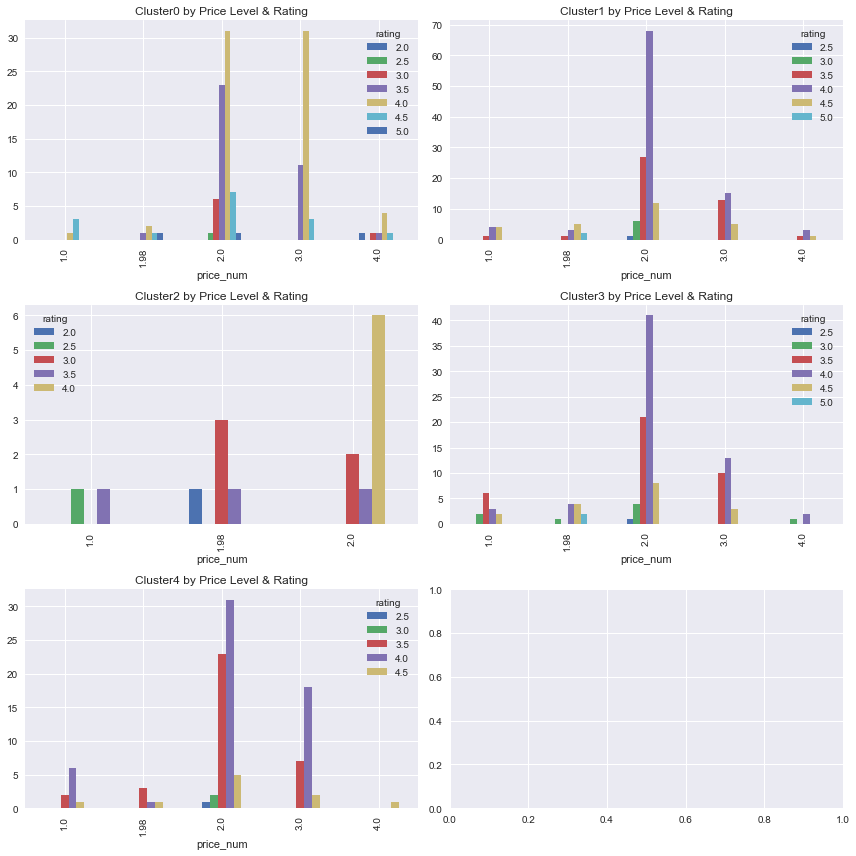

In [58]:
df_list = [cluster0,cluster1,cluster2,cluster3,cluster4]
COL_NUM = 2
ROW_NUM = 3
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i,df in enumerate(df_list):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    df.groupby(['price_num','rating']).size().unstack().plot(kind='bar',ax=ax,title=f"Cluster{i} by Price Level & Rating")

plt.tight_layout() 

### Compare Rating Between Clusters With Adjusted Rating

In [59]:
# Per Cluster Average Rating from Yelp
print('Average rating:', np.mean(cluster0['rating']))
print('Average rating:', np.mean(cluster1['rating']))
print('Average rating:', np.mean(cluster2['rating']))
print('Average rating:', np.mean(cluster3['rating']))
print('Average rating:', np.mean(cluster4['rating']))

Average rating: 3.854961832061069
Average rating: 3.921511627906977
Average rating: 3.375
Average rating: 3.86328125
Average rating: 3.8461538461538463


In [60]:
# Per Cluster Average Rating Looking at Authentic Users ONLY
print('Average adj rating:', np.mean(cluster0['avg_rate']))
print('Average adj rating:', np.mean(cluster1['avg_rate']))
print('Average adj rating:', np.mean(cluster2['avg_rate']))
print('Average adj rating:', np.mean(cluster3['avg_rate']))
print('Average adj rating:', np.mean(cluster4['avg_rate']))

Average adj rating: 3.906973067864582
Average adj rating: 3.9894034853006555
Average adj rating: 3.5076130010938495
Average adj rating: 3.924506819927835
Average adj rating: 3.9022315961618865


In [61]:
# Create New Dataframe to Compare between Yelp Rating and Adjusted Rating from 100 Reviews
index = [0,1,2,3,4]
columns = ['Avg_Rating','Adj_Rating']
df_rating = pd.DataFrame(index=index, columns=columns)
Avg_rating = np.array([np.mean(cluster0['rating']),np.mean(cluster1['rating']),
                       np.mean(cluster2['rating']),np.mean(cluster3['rating']),np.mean(cluster4['rating'])])
Adj_rating = np.array([np.mean(cluster0['avg_rate']),np.mean(cluster1['avg_rate']),
                       np.mean(cluster2['avg_rate']),np.mean(cluster3['avg_rate']),np.mean(cluster4['avg_rate'])])

df_rating['Avg_Rating'] = Avg_rating
df_rating['Adj_Rating'] = Adj_rating
df_rating

,Avg_Rating,Adj_Rating
0,3.854962,3.906973
1,3.921512,3.989403
2,3.375000,3.507613
3,3.863281,3.924507
4,3.846154,3.902232


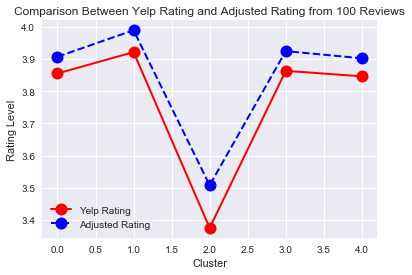

In [62]:
# Plot the Rating Difference
plt.plot(Avg_rating, color='red', marker='o',linewidth=2, markersize=12, label = 'Yelp Rating')
plt.plot(Adj_rating, color='blue', marker='o', linestyle='dashed',linewidth=2, markersize=12,label = 'Adjusted Rating')
plt.xlabel('Cluster')
plt.ylabel('Rating Level')
plt.title('Comparison Between Yelp Rating and Adjusted Rating from 100 Reviews')
plt.legend()
plt.show()

### Cluster-wise Service Type Analysis

In [63]:
# Cluster 0:
service_0 = service(cluster0)
service_0

({'delivery': 0.40539818278995243,
  'restaurant_reservation': 0.21942143238909864},
 {'pickup_p_value': 0.05381745827518604,
  'delivery_p_value': 0.18687757082003242,
  'restaurant_reservation_p_value': 0.1065808645443805})

In [64]:
# Cluster 1:
service_1 = service(cluster1)
service_1

({'pickup': 0.001800173713261466, 'delivery': 0.06657140455577082},
 {'pickup_p_value': 0.992161196736583,
  'delivery_p_value': 0.7120558742478765,
  'restaurant_reservation_p_value': 0.22839089017288264})

In [65]:
# Cluster 2:
service_2 = service(cluster2)
service_2

/Users/qihanliang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/qihanliang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qihanliang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/qihanliang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


({'pickup': 0.025641025641026105, 'delivery': 0.025641025641026105},
 {'pickup_p_value': 0.902300719031939,
  'delivery_p_value': 0.902300719031939,
  'restaurant_reservation_p_value': nan})

In [66]:
# Cluster 3:
service_3 = service(cluster3)
service_3

({'pickup': 0.049573722401260345,
  'restaurant_reservation': 0.20214513888399105},
 {'pickup_p_value': 0.8268098199319989,
  'delivery_p_value': 0.5382793011190001,
  'restaurant_reservation_p_value': 0.12482600974842231})

In [67]:
# Cluster 4:
service_4 = service(cluster4)
service_4

({'pickup': 0.3333333333333319, 'restaurant_reservation': 0.08333333333333393},
 {'pickup_p_value': 0.35794403234492345,
  'delivery_p_value': 0.30105803624007155,
  'restaurant_reservation_p_value': 0.5855088898216958})

## Topic Analysis

In [4]:
def get_text(cluster):
    text_list = ''
    for item in cluster['review']:
        text_list += str(item)
    return text_list

In [7]:
text_list0 = get_text(cluster0)
text_list1 = get_text(cluster1)
text_list2 = get_text(cluster2)
text_list3 = get_text(cluster3)
text_list4 = get_text(cluster4)

### Data Cleaning and Topic Analysis

In [ ]:
from operator import itemgetter
# 'Good' and 'great' are widely used in comments, because the common comments of resaurants are approximately positive. 
# So we delete 'good' and 'great'. And other words make no sense, we also delete them
Useless_words = ['will','one','great','good','-','really','italian']
def LDA_topic(sample,num,num_topics = 5,passes = 10,num_words=8,Useless_words=Useless_words):
    sentences = []
    for i in range(len(sample)):
        story=sample[i]
        sents = sent_tokenize(story)
        for index in range(len(sents)):
            sents[index] = sents[index].strip().replace('\n','').replace("\'","'")
        sentences.append('.'.join(sents))
    #convert the whole text into words
    texts = [[word for word in sentence.lower().split() 
            if word not in STOPWORDS and word.isalnum and word not in Useless_words]
            for sentence in sentences]
    
    #get the unique token in the texts
    dictionary = corpora.Dictionary(texts)
    #(word_id,freq) pairs by sentence,and generate index #bags of words
    corpus = [dictionary.doc2bow(txt) for txt in texts] 
    
    #Set parameters
    num_topics = num_topics #The number of topics that should be generated
    passes = passes # The num of passes to refine the model
    lda = LdaModel(corpus, #after dealing with frequencies
                  id2word=dictionary,#id to words
                  num_topics=num_topics,#how many topics wanted
                  passes=passes) #passes search through
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(lda.print_topics(num_words=num_words))#each topic can assoicate with more than a word #return 8 words
    
    list_ = sorted(lda.get_document_topics(corpus[0],minimum_probability=0,per_word_topics=False),key=itemgetter(1),reverse=True)
    print('For cluster{},the topic is'.format(num),lda.print_topic(topicno=list_[0][0]),'\n')
    
    return lda
    
#     return lda.print_topics(num_words=num_words)

In [62]:
text_list = [text_list0,text_list1,text_list2,text_list3,text_list4]
for index in range(len(text_list)):
    LDA_topic(sample = text_list[index],num = index)

[   (   0,
        '0.004*"pizza" + 0.004*"food" + 0.003*"place" + 0.003*"pasta" + '
        '0.002*"restaurant" + 0.002*"ordered" + 0.002*"got" + 0.002*"time"'),
    (   1,
        '0.000*"pizza" + 0.000*"place" + 0.000*"food" + 0.000*"restaurant" + '
        '0.000*"pasta" + 0.000*"us" + 0.000*"back" + 0.000*"service"'),
    (   2,
        '0.000*"food" + 0.000*"place" + 0.000*"pizza" + 0.000*"pasta" + '
        '0.000*"ordered" + 0.000*"came" + 0.000*"got" + 0.000*"back"'),
    (   3,
        '0.000*"food" + 0.000*"pizza" + 0.000*"place" + 0.000*"service" + '
        '0.000*"restaurant" + 0.000*"pasta" + 0.000*"ordered" + 0.000*"nice"'),
    (   4,
        '0.008*"food" + 0.008*"place" + 0.007*"pizza" + 0.006*"pasta" + '
        '0.005*"restaurant" + 0.005*"ordered" + 0.005*"service" + '
        '0.004*"back"')]
For cluster0,the topic is 0.008*"food" + 0.008*"place" + 0.007*"pizza" + 0.006*"pasta" + 0.005*"restaurant" + 0.005*"ordered" + 0.005*"service" + 0.004*"back" + 0.004*"got" 

### Sentimental Analysis on Picked Features by Cluster

In [63]:
word_batch = ['place','food','service','pizza','pasta','restaurant']
def get_sent(text_list,word_batch=word_batch):
    word_list = []
    text1 = sent_tokenize(text_list)
    for word in word_batch:
        for sent in text1:
            if word in sent:
                word_list.append(sent)
    word_set = set(word_list)
    word_str = ' '.join(list(word_set))
    return word_str

In [64]:
text_str0 = get_sent(text_list0)
text_str1 = get_sent(text_list1)
text_str2 = get_sent(text_list2)
text_str3 = get_sent(text_list3)
text_str4 = get_sent(text_list4)

In [65]:
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        index = 0
        while index < len(word_list): #do cleaning
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list

    #Get lists of positive and negative words
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt' #list of positive words
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)#clean the words
    negative_words = get_words(n_url)
    return positive_words,negative_words

positive_words,negative_words = get_pos_neg_words()

In [66]:
def do_pos_neg_sentiment_analysis(text_list,debug=False):
    positive_words,negative_words = get_pos_neg_words()
    from nltk import word_tokenize
    results = list()
    for text in text_list:
        cpos = cneg = lpos = lneg = 0
        for word in word_tokenize(text[1]):
            if word in positive_words:
                if debug: 
                    print("Positive",word)
                cpos+=1
            if word in negative_words:
                if debug:
                    print("Negative",word)
                cneg+=1
        results.append((text[0],cpos/len(word_tokenize(text[1])),cneg/len(word_tokenize(text[1])))) #normlaized by length
    return results

pos_neg = do_pos_neg_sentiment_analysis([('cluster0',text_str0),('cluster1',text_str1),('cluster2',text_str2),('cluster3',text_str3),('cluster4',text_str4)])
pos_neg

[('cluster0', 0.055721669100568576, 0.013975408529966987),
 ('cluster1', 0.057905523801577034, 0.014226709499770536),
 ('cluster2', 0.05532623169107856, 0.01613404349755881),
 ('cluster3', 0.05686747243736126, 0.014189667045712383),
 ('cluster4', 0.05805859847862149, 0.014634674876331953)]

### Sentiment Analysis by Cluster

In [71]:
def get_sentiment_analysis(df):
    df=df.dropna()
    
    def get_nrc_data():
        nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
        count=0
        emotion_dict=dict()
        with open(nrc,'r') as f:
            all_lines = list()
            for line in f:
                if count < 46:
                    count+=1
                    continue
                line = line.strip().split('\t')
                if int(line[2]) == 1:
                    if emotion_dict.get(line[0]):
                        emotion_dict[line[0]].append(line[1])
                    else:
                        emotion_dict[line[0]] = [line[1]]
        return emotion_dict
    emotion_dict=get_nrc_data()

    def emotion_analyzer(text,emotion_dict):
        #Set up the result dictionary
        emotions = {x for y in emotion_dict.values() for x in y}
        emotion_count = dict()
        for emotion in emotions:
            emotion_count[emotion] = 0

        #Analyze the text and normalize by total number of words
        total_words = len(text.split())
        for word in text.split():
            if emotion_dict.get(word):
                for emotion in emotion_dict.get(word):
                    emotion_count[emotion] += 1/len(text.split())
        return emotion_count

    def get_sentiment_analysis(df,emotion_dict):
        #import and clean data
        df=df.drop(['price'], axis=1)
        df=df.dropna()
        df=df.reset_index(drop=True)

        output=pd.DataFrame(columns=['Restaurant','Fear','Trust','Negative',
                               'Positive','Joy','Disgust','Anticipation',
                               'Sadness','Surprise'])
        output['Restaurant']=df['alias']
        output.set_index('Restaurant',inplace=True)

        for x in range(len(df['review'])):
            result=emotion_analyzer(df['review'].iloc[x], emotion_dict)
            output.iloc[x]=[result['fear'],result['trust'],
                      result['negative'],result['positive'],result['joy'],result['disgust'],
                      result['anticipation'],result['sadness'],result['surprise']]
        return output

    return get_sentiment_analysis(df,emotion_dict)
  

#### Cluster 0

In [72]:
sentiment0 = get_sentiment_analysis(cluster0)

In [73]:
sentiment0

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise
Restaurant,,,,,,,,,
momofuku-nishi-new-york,0.00437765,0.0245018,0.0134597,0.0405096,0.0226723,0.0035936,0.0173799,0.00594577,0.00947403
pepe-giallo-new-york,0.00538876,0.0291433,0.0139668,0.0486088,0.0307929,0.00428901,0.0241944,0.00516881,0.0101177
ovest-pizzoteca-by-luzzos-new-york,0.00462606,0.0247687,0.0132999,0.0383577,0.0234194,0.00520432,0.0182151,0.00558982,0.00761372
scarpetta-new-york,0.00370397,0.0248593,0.0130351,0.0426669,0.0252155,0.00491488,0.0168815,0.00584087,0.00819147
zia-maria-chelsea-new-york-2,0.00532435,0.0256438,0.0116266,0.0416169,0.0241226,0.00358579,0.0221667,0.00619363,0.0101054
vago-restaurant-new-york,0.00494547,0.0294192,0.0109054,0.0497083,0.029546,0.00380421,0.0204159,0.00710119,0.00836926
the-meatball-shop-new-york-4,0.00673733,0.0224578,0.0123069,0.0430291,0.0244341,0.00368308,0.0216493,0.00583902,0.0114086
ulivo-new-york-2,0.00379651,0.0262501,0.0149691,0.042087,0.0251654,0.00531511,0.0163792,0.00835232,0.0072676
sams-place-new-york,0.00614145,0.0327224,0.0128587,0.0461568,0.0306113,0.00412628,0.0199597,0.00950005,0.0102677


#### Cluster 1

In [74]:
sentiment1 = get_sentiment_analysis(cluster1)
sentiment1

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise
Restaurant,,,,,,,,,
babbalucci-new-york,0.00348028,0.0273149,0.0125501,0.0437671,0.0260494,0.00316389,0.0226745,0.00558954,0.00790972
pisticci-new-york,0.00384098,0.0299597,0.0107548,0.0492606,0.0320722,0.00316881,0.0231419,0.00499328,0.0113309
vinatería-new-york-4,0.00408197,0.0274075,0.0139953,0.0422359,0.0255748,0.00483172,0.0204932,0.0074142,0.0102466
sottocasa-pizzeria-harlem-new-york,0.00384869,0.0279305,0.0124258,0.0450847,0.0285903,0.00296899,0.0239718,0.00538817,0.00879701
grazie-new-york-3,0.00538581,0.0286898,0.0141895,0.0467115,0.0275505,0.00362506,0.0213361,0.00590368,0.00942517
lido-new-york,0.00601719,0.0324737,0.0101242,0.0496657,0.0311366,0.00219675,0.0207259,0.00487106,0.00840497
max-soha-new-york,0.00620412,0.0298832,0.0125116,0.04529,0.029573,0.00279185,0.0215076,0.00630752,0.00868576
raos-new-york,0.0058304,0.0251111,0.0128153,0.0412746,0.023033,0.00415632,0.016683,0.00594585,0.0106217
patsys-pizzeria-new-york-7,0.00381526,0.0190763,0.0128514,0.0314257,0.0158635,0.00371486,0.0168675,0.00461847,0.00572289


#### Cluster 2

In [75]:
sentiment2 = get_sentiment_analysis(cluster2)
sentiment2

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise
Restaurant,,,,,,,,,
fumo-pizza-bar-pasta-new-york-3,0.00512408,0.0275294,0.0101477,0.0484276,0.0305436,0.00251181,0.0241133,0.00452125,0.00854014
anchor-wine-bar-new-york-3,0.00342365,0.0297369,0.0116404,0.0466595,0.0292478,0.00352147,0.0191725,0.00567348,0.00811895
bono-trattoria-new-york,0.00466362,0.0281802,0.0129986,0.0430641,0.0288748,0.00446517,0.0230204,0.00506053,0.0101211
saggio-new-york-2,0.00521071,0.0269677,0.0162721,0.0428741,0.0268763,0.00393089,0.0196544,0.00676479,0.0074047
antika-restaurant-and-pizzeria-new-york,0.00504401,0.0243299,0.0128573,0.0411433,0.021264,0.00346158,0.0219563,0.00583523,0.00810998
zoe-restaurant-bar-new-york,0.00903862,0.0386196,0.0131471,0.0517666,0.0353328,0.00657354,0.0353328,0.00986031,0.010682
anchor-heights-new-york,0.00389579,0.0258096,0.0113221,0.0448016,0.0273923,0.00316533,0.0210616,0.00486973,0.00949598
il-sole-new-york,0.00658962,0.0255474,0.0145985,0.040146,0.0243309,0.00435929,0.0202758,0.00709651,0.00780616
aquamarina-new-york,0.0079082,0.0274461,0.0120949,0.0440378,0.0265157,0.0041867,0.0217088,0.00728795,0.00899364


#### Cluster 3

In [76]:
sentiment3 = get_sentiment_analysis(cluster3)
sentiment3

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise
Restaurant,,,,,,,,,
misirizzi-new-york,0.00282087,0.0303244,0.0156323,0.0512459,0.0329102,0.00317348,0.0231547,0.00681711,0.0131641
vics-new-york,0.00522436,0.0244758,0.0111644,0.0414371,0.0251199,0.00329206,0.0185357,0.00465183,0.00801546
piccola-strada-new-york,0.00536097,0.0266262,0.0161723,0.0399392,0.0252859,0.00312723,0.0189421,0.00589707,0.0104539
otto-enoteca-pizzeria-new-york,0.00427411,0.026642,0.013321,0.040889,0.0240775,0.00548511,0.0188773,0.00633993,0.00904687
gemma-new-york,0.00282992,0.0263183,0.0121687,0.0417885,0.0259409,0.00292425,0.0186775,0.00405622,0.00877276
il-buco-alimentari-and-vineria-new-york-2,0.00438394,0.0229965,0.0159975,0.037302,0.0216121,0.00607599,0.0170743,0.00676819,0.00922935
sorbillo-pizzeria-new-york,0.0036062,0.0240714,0.0118103,0.0376848,0.020375,0.00315543,0.0173999,0.00450775,0.0100974
frank-new-york,0.0063822,0.0260759,0.0148614,0.0420314,0.0248906,0.0039205,0.0217907,0.00510576,0.00820569
cacio-e-vino-new-york,0.00393021,0.0273198,0.0121741,0.0403566,0.0259778,0.00316334,0.0192676,0.00603911,0.00891488


#### Cluster 4

In [78]:
sentiment4 = get_sentiment_analysis(cluster4)
sentiment4

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise
Restaurant,,,,,,,,,
tessa-new-york,0.00324708,0.0265855,0.0101471,0.0457636,0.0256722,0.00304414,0.017859,0.00436327,0.00821918
parm-new-york-2,0.0106316,0.0227225,0.0117782,0.0382531,0.0217844,0.00385658,0.0187617,0.00469043,0.0104232
pappardella-new-york,0.0057634,0.0312437,0.0152679,0.0471183,0.0275025,0.00566229,0.0231547,0.00819009,0.0115268
salumeria-rosi-new-york-4,0.00360808,0.0286241,0.0177999,0.04466,0.0263791,0.00408916,0.0217287,0.00665491,0.0105035
vai-restaurant-new-york-3,0.00472298,0.0276113,0.015168,0.0441417,0.0269755,0.00554042,0.0218892,0.00626703,0.0112625
my-pie-new-york-5,0.00406377,0.01985,0.013598,0.0340731,0.0196937,0.00265708,0.0173492,0.00484526,0.0101594
da-capo-columbus-new-york,0.00599187,0.0273914,0.0160496,0.043655,0.0252514,0.00406591,0.0199016,0.00984378,0.0089878
storico-new-york,0.00396323,0.0277426,0.0130702,0.0501729,0.0290918,0.00438486,0.0215027,0.00657728,0.0104562
sole-bistro-italiano-new-york,0.00580169,0.0279536,0.0205696,0.0400844,0.024789,0.00896624,0.0174051,0.0105485,0.00949367


### Word Cloud on Restaurant Reviews per Cluster

In [79]:
def find_top_and_last_review(sentiment):
    sentiment["All_Pos"]=(sentiment['Trust']+sentiment['Positive']+ sentiment['Joy']+ sentiment['Anticipation'])
    sentiment["All_Neg"]=(sentiment['Fear']+sentiment['Negative']+ sentiment['Disgust']+ sentiment['Sadness'])
    sentiment['Net']=sentiment["All_Pos"]-sentiment["All_Neg"]
    sentiment.sort_values(by="Net",ascending=False)['Net']
    top3=(sentiment.sort_values(by="Net",ascending=False)['Net'].index[:3],sentiment.sort_values(by="Net",ascending=False)['Net'][:3])
    last3=(sentiment.sort_values(by="Net",ascending=False)['Net'].index[-3:],sentiment.sort_values(by="Net",ascending=False)['Net'][-3:])
    review_top3=''
    for x in range(3):
        review_top3+=df[df['alias']==top1[0][x]]['review'].values[0]
    review_last3=''
    for x in range(3):
        review_last3+=df[df['alias']==last1[0][x]]['review'].values[0]
    return review_top3,review_last3

In [87]:
def get_cluster_cloud():
    def find_cluster_review(df):
        string=''
        for x in df['review']:
            string+=str(x)
        return string
    
    review0=find_cluster_review(cluster0)
    review1=find_cluster_review(cluster1)
    review2=find_cluster_review(cluster2)
    review3=find_cluster_review(cluster3)
    review4=find_cluster_review(cluster4)
    
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    %matplotlib inline
    #Remove unwanted words
    #As we look at the cloud, we can get rid of words that don't make sense by adding them to this variable
    DELETE_WORDS = []
    def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
        for word in DELETE_WORDS:
            text_string = text_string.replace(word,' ')
        return text_string

    #Remove short words
    MIN_LENGTH = 0
    def remove_short_words(text_string,min_length = MIN_LENGTH):
        word_list = text_string.split()
        for word in word_list:
            if len(word) < min_length:
                text_string = text_string.replace(' '+word+' ',' ',1)
        return text_string


    #Set up side by side clouds
    COL_NUM = 2
    ROW_NUM = 3
    fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))
    import nltk
    from nltk.stem.porter import PorterStemmer
    from nltk import sent_tokenize,word_tokenize 
    p_stemmer = PorterStemmer()
    text=[review0, review1, review2, review3, review4]
    title=["c0","c1", "c2","c3", "c4"]
    for i in range(5):
        text_string = remove_words(text[i])
        text_string = remove_short_words(text_string)
        ax = axes[i//2, i%2] 
        ax.set_title(title[i])
        wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(text_string)
        ax.imshow(wordcloud)
    #     else:
    #         striptext = text_string.replace('\xa0', ' ')
    #         striptext = striptext.replace('\'', "'")
    #         sentences = sent_tokenize(striptext)
    #         words = word_tokenize(striptext)
    #         text = nltk.Text([p_stemmer.stem(i).lower() for i in words])
    #         text.dispersion_plot(["service", "food", "price", "place",'taste','pasta','pizza'])
        ax.axis('off')

    plt.show()

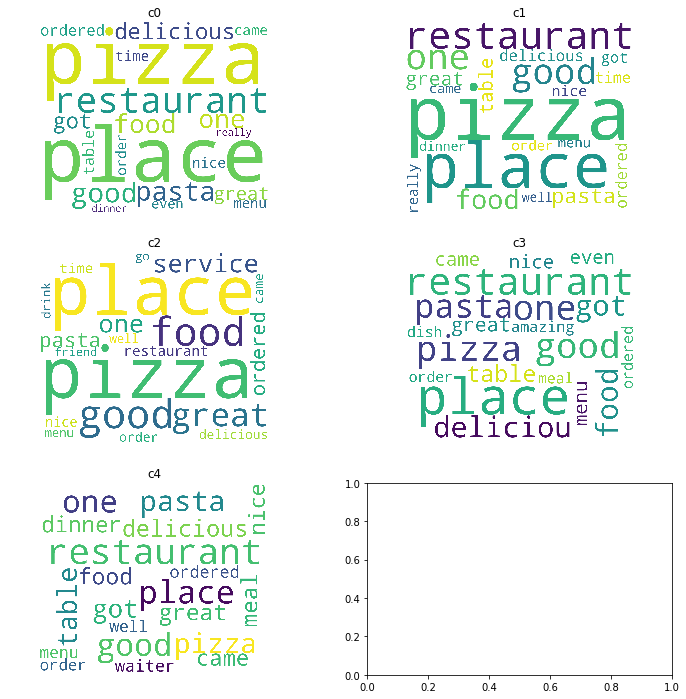

In [88]:
c = get_cluster_cloud()
c